In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout


In [9]:
#loading prepared data
train_set=pd.read_csv('train_set_new.csv')
val_set=pd.read_csv('val_set_new.csv')
test_set=pd.read_csv('test_set_new.csv')

In [3]:
#set date as an index
train_set = train_set.set_index('Date')
val_set = val_set.set_index('Date')
test_set = test_set.set_index('Date')

print(train_set.shape, val_set.shape, test_set.shape)

train_set.head()

(359432, 17) (62138, 17) (115064, 17)


,Store,Dept,Unemployment,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Week,Year,Weekly_Sales
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,1,8.106,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,5,2010,24924.50
2010-02-12,1,1,8.106,1,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,6,2010,46039.49
2010-02-19,1,1,8.106,0,1,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,7,2010,41595.55
2010-02-26,1,1,8.106,0,1,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8,2010,19403.54
2010-03-05,1,1,8.106,0,1,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,9,2010,21827.90


In [4]:
#change data from df to array
train_array=np.array(train_set)
val_array=np.array(val_set)
test_array=np.array(test_set)

In [5]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#Here the n_features is 16. We will make timesteps = 12 (past weeks data used for training). 

n_future =1
n_past =12

#Reformat train data into a shape: (n_samples x timesteps x n_features)

train_x =[]
train_y = []

for i in range(n_past, len(train_set) - n_future+1):
    train_x.append(train_array[i-n_past:i, 0:train_set.shape[1]-1])
    train_y.append(train_array[i+n_future-1:i+n_future, train_set.shape[1]-1])
    

train_x, train_y = np.array(train_x), np.array(train_y)

#Reformat validation data into a shape: (n_samples x timesteps x n_features)

val_x =[] 
val_y = []
for i in range(n_past, len(val_set) - n_future+1):
    val_x.append(val_array[i-n_past:i, 0:val_set.shape[1]-1]) 
    val_y.append(val_array [i+n_future-1:i+n_future, val_set.shape[1]-1])
    

val_x, val_y = np.array(val_x), np.array(val_y)

In [6]:
# define the model 
lstm_model = keras.Sequential()
lstm_model.add(LSTM(64, activation='relu',input_shape=(train_x.shape[1],train_x.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.4))
lstm_model.add(LSTM(32, activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(train_y.shape[1]))
lstm_model.compile(optimizer='adam', loss='mse',metrics=['mse',"mean_absolute_percentage_error"])
lstm_model.summary()
# fit the model
history =lstm_model.fit(train_x, train_y,validation_split=0.1, epochs=50, verbose=1)


train_loss = lstm_model.evaluate(train_x, train_y, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 64)            20736     
_________________________________________________________________
dropout (Dropout)            (None, 12, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 33,185
Trainable params: 33,185
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10109/10109 [==============================] - 125s 12ms/step - loss: 585647168.0000 - mse: 585647168.0000 

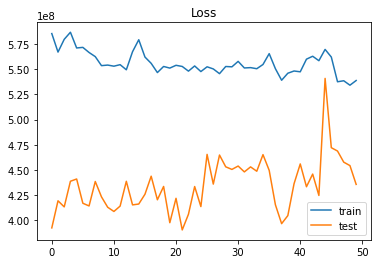

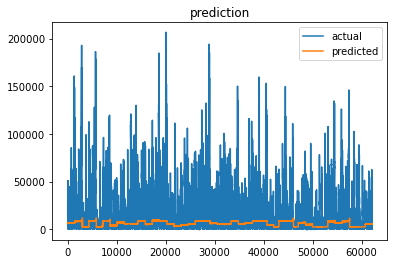

In [10]:
# plot loss during training
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

y_val_pred = lstm_model.predict(val_x)

plt.title('prediction')
plt.plot(val_y, label='actual')
plt.plot(y_val_pred, label='predicted')
plt.legend()
plt.show()

In [15]:
#save  the predictions with original sales
unscaled_val_pred=pd.DataFrame()
unscaled_val_pred['Date']=val_set[n_past:len(val_set)].Date
unscaled_val_pred['Store']=val_set[n_past:len(val_set)].Store
unscaled_val_pred['Weekly_Sales']=val_set[n_past:len(val_set)].Weekly_Sales
unscaled_val_pred['Prediction']=y_val_pred

unscaled_val_pred.to_csv('unscaled_val_pred.csv')
unscaled_val_pred


,Date,Store,Weekly_Sales,Prediction
12,2012-08-31,1,16680.24,6443.229980
13,2012-09-07,1,18322.37,6489.556641
14,2012-09-14,1,19616.22,6467.784180
15,2012-09-21,1,19251.50,6484.938965
16,2012-09-28,1,18947.81,6470.578125
...,...,...,...,...
62133,2012-09-28,45,508.37,5408.816895
62134,2012-10-05,45,628.10,5404.446289
62135,2012-10-12,45,1061.02,5434.706055
62136,2012-10-19,45,760.01,5418.714844
